<a href="https://colab.research.google.com/github/AditiCoderElite/Variance-Inflation-Factor/blob/main/Variance_Inflation_Factor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variance Inflation Factor

---

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


csv_file = 'https://s3-student-datasets-bucket.whjr.online/whitehat-ds-datasets/air-quality/AirQualityUCI.csv'
df = pd.read_csv(csv_file, sep=';')


df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16'], axis=1)


df = df.dropna()


dt_series = pd.Series(data = [item.split("/")[2] + "-" + item.split("/")[1] + "-" + item.split("/")[0] for item in df['Date']], index=df.index) + ' ' + pd.Series(data=[str(item).replace(".", ":") for item in df['Time']], index=df.index)
dt_series = pd.to_datetime(dt_series)

df = df.drop(columns=['Date', 'Time'], axis=1)
df.insert(loc=0, column='DateTime', value=dt_series)


year_series = dt_series.dt.year


month_series = dt_series.dt.month


day_series = dt_series.dt.day


day_name_series = dt_series.dt.day_name()


df['Year'] = year_series
df['Month'] = month_series
df['Day'] = day_series
df['Day Name'] = day_name_series


df = df.sort_values(by='DateTime')

def comma_to_period(series):
    new_series = pd.Series(data=[float(str(item).replace(',', '.')) for item in series], index=df.index)
    return new_series


cols_to_correct = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
for col in cols_to_correct:
    df[col] = comma_to_period(df[col])


df = df.drop(columns=['NMHC(GT)', 'CO(GT)', 'NOx(GT)', 'NO2(GT)'], axis=1)


aq_2004_df = df[df['Year'] == 2004]
aq_2005_df = df[df['Year'] == 2005]


for col in aq_2004_df.columns[1:-4]:
  median = aq_2004_df.loc[aq_2004_df[col] != -200, col].median()
  aq_2004_df[col] = aq_2004_df[col].replace(to_replace=-200, value=median)


for col in aq_2005_df.columns[1:-4]:
  median = aq_2005_df.loc[aq_2005_df[col] != -200, col].median()
  aq_2005_df[col] = aq_2005_df[col].replace(to_replace=-200, value=median)


group_2004_month = aq_2004_df.groupby(by='Month')
group_2005_month = aq_2005_df.groupby(by='Month')


df = pd.concat([aq_2004_df, aq_2005_df])


df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DateTime       9357 non-null   datetime64[ns]
 1   PT08.S1(CO)    9357 non-null   float64       
 2   C6H6(GT)       9357 non-null   float64       
 3   PT08.S2(NMHC)  9357 non-null   float64       
 4   PT08.S3(NOx)   9357 non-null   float64       
 5   PT08.S4(NO2)   9357 non-null   float64       
 6   PT08.S5(O3)    9357 non-null   float64       
 7   T              9357 non-null   float64       
 8   RH             9357 non-null   float64       
 9   AH             9357 non-null   float64       
 10  Year           9357 non-null   int32         
 11  Month          9357 non-null   int32         
 12  Day            9357 non-null   int32         
 13  Day Name       9357 non-null   object        
dtypes: datetime64[ns](1), float64(9), int32(3), object(1)
memory usage: 986.9+ KB

---

#### Multiple Linear Regression Model Using `sklearn` Module


In [4]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

features = list(df.columns.values[1:-1])
features.remove('RH')

X = df[features]
y = df['RH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

sklearn_lin_reg = LinearRegression()
sklearn_lin_reg.fit(X_train, y_train_reshaped)

print("\nConstant".ljust(15, " "), f"{sklearn_lin_reg.intercept_[0]:.6f}")

for item in list(zip(X.columns.values, sklearn_lin_reg.coef_[0])):
  print(f"{item[0]}".ljust(15, " "), f"{item[1]:.6f}")


Constant       -15028.451823
PT08.S1(CO)     0.014833
C6H6(GT)        -0.903464
PT08.S2(NMHC)   -0.005881
PT08.S3(NOx)    0.001503
PT08.S4(NO2)    0.026497
PT08.S5(O3)     -0.001066
T               -2.354919
AH              29.551742
Year            7.505153
Month           1.167861
Day             0.035232


In [5]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_train_pred = sklearn_lin_reg.predict(X_train)
y_test_pred = sklearn_lin_reg.predict(X_test)

print(f"Train Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_train_reshaped, y_train_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train_reshaped, y_train_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train_reshaped, y_train_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train_reshaped, y_train_pred):.3f}")

print(f"\n\nTest Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_test_reshaped, y_test_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test_reshaped, y_test_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test_reshaped, y_test_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_reshaped, y_test_pred):.3f}")

Train Set
--------------------------------------------------
R-squared: 0.879
Mean Squared Error: 35.116
Root Mean Squared Error: 5.926
Mean Absolute Error: 4.572


Test Set
--------------------------------------------------
R-squared: 0.879
Mean Squared Error: 34.702
Root Mean Squared Error: 5.891
Mean Absolute Error: 4.564


---

#### The `statsmodels.api` Module

In [6]:
import statsmodels.api as sm

X = df[features]
y = df['RH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

X_train_sm = sm.add_constant(X_train)

lr = sm.OLS(y_train, X_train_sm).fit()

lr.params

const           -15028.451823
PT08.S1(CO)          0.014833
C6H6(GT)            -0.903464
PT08.S2(NMHC)       -0.005881
PT08.S3(NOx)         0.001503
PT08.S4(NO2)         0.026497
PT08.S5(O3)         -0.001066
T                   -2.354919
AH                  29.551742
Year                 7.505153
Month                1.167861
Day                  0.035232
dtype: float64

In [8]:
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                     RH   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     4115.
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        09:56:57   Log-Likelihood:                -20050.
No. Observations:                6269   AIC:                         4.012e+04
Df Residuals:                    6257   BIC:                         4.020e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.503e+04   1240.167    -12.118

---

#### Multicollinearity

In [9]:
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                     RH   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     4115.
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        09:57:05   Log-Likelihood:                -20050.
No. Observations:                6269   AIC:                         4.012e+04
Df Residuals:                    6257   BIC:                         4.020e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.503e+04   1240.167    -12.118

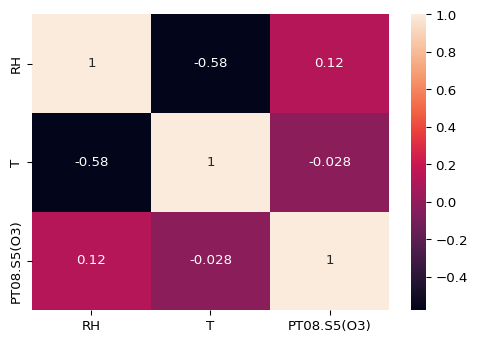

In [14]:
plt.figure(figsize = (6, 4), dpi = 96)
sns.heatmap(df[['RH', 'T', 'PT08.S5(O3)']].corr(), annot = True)
plt.show()

In [15]:
X_train = X_train[['T', 'PT08.S5(O3)']]
X_test = X_test[['T', 'PT08.S5(O3)']]

X_train_sm1 = sm.add_constant(X_train)

lr1 = sm.OLS(y_train, X_train_sm1).fit()

lr1.params

const          64.956429
T              -1.104251
PT08.S5(O3)     0.004509
dtype: float64

In [16]:
df['PT08.S5(O3)'].std() / np.sqrt(df['PT08.S5(O3)'].mean())
print(df['T'].std() / np.sqrt(df['T'].mean()))

2.045765864631692


In [17]:
print(lr1.summary())

                            OLS Regression Results                            
Dep. Variable:                     RH   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     1580.
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        09:58:38   Log-Likelihood:                -25378.
No. Observations:                6269   AIC:                         5.076e+04
Df Residuals:                    6266   BIC:                         5.078e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          64.9564      0.623    104.206      

---

#### Variance Inflation Factor Math

Variance Infation Factor (VIF) is a way to detect multicollinearity between independent variables in a dataset. We calculate the VIF values to measure the extent of multicollinearity between the independent variables.  

For $k$ different independent variables, we can calculate $k$ different VIFs (one for each $x_i$ where $i = 1, 2, 3, \dots, k$) in three steps:

**Step one**

First, build a multiple linear regression model wherein $x_i$ is a target variable and it is a function of all the other feature variables as illustrated in the equation below.

$$x_1 = \beta_0^* + \beta_2^* x_2 + \beta_3^* x_3 + \beta_4^* x_4 + \dots + \beta_k^* x_k + \epsilon^*$$

Here,

- $x_1$ is a feature acting as the target (or dependent) variable in above equation

- $x_2, x_3, x_4, \dots , x_k$ are independent variables or features

- $\beta_0^*, \beta_2^*, \beta_3^*, \dots, \beta_k^*$ are the corresponding regression coefficients of the independent variables in the above linear regression equation

- **$\epsilon^*$** is the random error obtained along with the predicted value

**Step two**

Then, calculate the VIF for $x_{i}$ using the following formula:

$$\text{VIF}_{i} = \frac{1}{1-R_{i}^{2}}$$

where $R^2 _i$ is the coefficient of determination of the regression equation in step one, with $x_{1}$ on the left hand side, and all other independent variables on the right hand side.

**Step three**

Analyse the extent of multicollinearity by considering the magnitude of the $\text{VIF}_{i}$. **A rule of thumb is that if $\text{VIF}_{i} > 10$, then multicollinearity is high. In that case, the $x_i$ feature must be dropped to predict the values of the target (or dependent) variable.** A cutoff of 5 is also commonly used.



In [18]:
X = df[['T', 'PT08.S5(O3)', 'PT08.S1(CO)']]
y = df['RH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)


X_train_sm2 = sm.add_constant(X_train)

lr2 = sm.OLS(y_train, X_train_sm2).fit()


lr2.params

const          53.560416
T              -1.141346
PT08.S5(O3)    -0.005377
PT08.S1(CO)     0.020191
dtype: float64

In [19]:

print(lr2.summary())

                            OLS Regression Results                            
Dep. Variable:                     RH   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     1111.
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        09:59:27   Log-Likelihood:                -25322.
No. Observations:                6269   AIC:                         5.065e+04
Df Residuals:                    6265   BIC:                         5.068e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          53.5604      1.233     43.454      

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['Features'] = X_train_sm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_sm2.values, i) for i in range(X_train_sm2.values.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,50.42
2,PT08.S5(O3),5.29
3,PT08.S1(CO),5.29
1,T,1.03


In [21]:
ozone_X_train = X_train[['T', 'PT08.S1(CO)']]
ozone_y_train = X_train['PT08.S5(O3)']

ozone_X_train_sm = sm.add_constant(ozone_X_train)
ozone_lin_reg = sm.OLS(ozone_y_train, ozone_X_train_sm).fit()

print(ozone_lin_reg.summary())

                            OLS Regression Results                            
Dep. Variable:            PT08.S5(O3)   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                 1.344e+04
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        09:59:55   Log-Likelihood:                -41052.
No. Observations:                6269   AIC:                         8.211e+04
Df Residuals:                    6266   BIC:                         8.213e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -735.6783     11.968    -61.473      

In [22]:
ozone_vif = 1 / (1 - 0.811)
ozone_vif

5.291005291005293

In [23]:
temp_X_train = X_train[['PT08.S1(CO)', 'PT08.S5(O3)']]
temp_y_train = X_train['T']

temp_X_train_sm = sm.add_constant(temp_X_train)
temp_lin_reg = sm.OLS(temp_y_train, temp_X_train_sm).fit()

print(temp_lin_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      T   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     99.88
Date:                Thu, 18 Apr 2024   Prob (F-statistic):           2.00e-43
Time:                        10:00:09   Log-Likelihood:                -22368.
No. Observations:                6269   AIC:                         4.474e+04
Df Residuals:                    6266   BIC:                         4.476e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.4571      0.760     12.442      

In [24]:
temp_vif = 1 / (1 - 0.031)
temp_vif

1.0319917440660475

---

#### Calculating VIFs for Previously Built Model



In [25]:

vif = pd.DataFrame()
vif['Features'] = X_train_sm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_sm1.values, i) for i in range(X_train_sm1.values.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,12.67
1,T,1.00
2,PT08.S5(O3),1.00


In [26]:
print(lr1.summary())

                            OLS Regression Results                            
Dep. Variable:                     RH   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     1580.
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        10:00:34   Log-Likelihood:                -25378.
No. Observations:                6269   AIC:                         5.076e+04
Df Residuals:                    6266   BIC:                         5.078e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          64.9564      0.623    104.206      

In [27]:
def predict_relative_humidity(temperature, ozone):
  relative_humidity = 64.9564 - 1.1043 * temperature + 0.0045 * ozone
  return relative_humidity

predicted_relative_humidity = predict_relative_humidity(30, 900)
predicted_relative_humidity

35.877399999999994

---

#### Rebuilding Linear Regression Model Using The `sklearn` Module


In [28]:
X_train = X_train[['T', 'PT08.S5(O3)']]

y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)


final_lin_reg = LinearRegression()
final_lin_reg.fit(X_train, y_train_reshaped)


print("\nConstant".ljust(15, " "), f"{final_lin_reg.intercept_[0]:.4f}")


for item in list(zip(X_train.columns.values, final_lin_reg.coef_[0])):
  print(f"{item[0]}".ljust(15, " "), f"{item[1]:.4f}")


Constant       64.9564
T               -1.1043
PT08.S5(O3)     0.0045


In [29]:
X_test = X_test[['T', 'PT08.S5(O3)']]

final_y_train_pred = final_lin_reg.predict(X_train)
final_y_test_pred = final_lin_reg.predict(X_test)

print(f"Train Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_train_reshaped, final_y_train_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train_reshaped, final_y_train_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train_reshaped, final_y_train_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train_reshaped, final_y_train_pred):.3f}")

print(f"\n\nTest Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_test_reshaped, final_y_test_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test_reshaped, final_y_test_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test_reshaped, final_y_test_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_reshaped, final_y_test_pred):.3f}")

Train Set
--------------------------------------------------
R-squared: 0.335
Mean Squared Error: 192.217
Root Mean Squared Error: 13.864
Mean Absolute Error: 11.216


Test Set
--------------------------------------------------
R-squared: 0.361
Mean Squared Error: 182.890
Root Mean Squared Error: 13.524
Mean Absolute Error: 11.048


As you can see, there is hardly any improvement in the performance of the linear regression model after considering ozone as another independent variables to predict the relative humidity values. Hence, we can conclude either of the following from this result:

1. In general, the relative humidity values cannot be predicted accurately using temperature and ozone.

2. In particular, the linear regression model cannot accurately predict the relative humidity values from the ozone and temperature values.

It might happen many a times that a particular problem cannot be solved using a particlar machine learning algorithm. Hence, you might have to use other algorithms to solve that problem. By experience i.e. by solving more and more problems, you will learn to apply the most appropriate machine learning algorithm to solve a problem.

